In [54]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np

set_seed(1234)

# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [16]:
dataset_name = DatasetName.RADIOML_2016
radioml2016b_path = cur_dir + "/data/RML2016.10b/RML2016.10b.dat"
radioml2016a_path = cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl"
dataset_path = os.path.abspath(radioml2016a_path)
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)

# Create Model
Create convolutional model

In [55]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName

# cnn_1d_v012_1_configuration = Convolution01xConfiguration(
#     input_shape=(128, 2),
#     n_classes=len(radioml_ds.get_modulations()),
#     output_channels=[32, 48, 64, 96, 128, 192],
#     kernel_sizes=[8, 8, 8, 8, 8, 8],
#     paddings=["same", "same", "same", "same", "same", "same"],
#     max_pool_sizes=[1, 1, 2, 1, 2, 1],
#     max_pool_strides=[1, 1, 2, 1, 2, 1],
#     avg_size=32,
#     dense_sizes=[],
# )

# cnn_1d_v012_2_configuration = Convolution01xConfiguration(
#     input_shape=(128, 2),
#     n_classes=len(radioml_ds.get_modulations()),
#     output_channels=[32, 48, 64, 96],
#     kernel_sizes=[8, 8, 8, 8],
#     paddings=["same", "same", "same", "same",],
#     max_pool_sizes=[1, 2, 2, 1],
#     max_pool_strides=[1, 2, 2, 1],
#     avg_size=32,
#     dense_sizes=[96],
# )
model_name = "cnn_1d_v012_2.6_radio_ml"

cnn_1d_v012_3_configuration = Convolution01xConfiguration(
    input_shape=(128, 2),
    n_classes=len(radioml_ds.get_modulations()),
    output_channels=[32, 48, 64, 96],
    kernel_sizes=[8, 8, 8, 8],
    paddings=["same", "same", "same", "same",],
    max_pool_sizes=[1, 2, 2, 1],
    max_pool_strides=[1, 2, 2, 1],
    avg_size=32,
    dense_sizes=[96],
)

model_configuration = cnn_1d_v012_3_configuration

model = make_sigmod_model(ModelName.CNN_1D_V012, model_configuration)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN0_ (Conv1D)              (None, 128, 32)           544       
                                                                 
 MAX_POOL_0_ (MaxPooling1D)  (None, 128, 32)           0         
                                                                 
 BN0_ (CustomBatchNorm)      (None, 128, 32)           128       
                                                                 
 CNN_REL0_ (ReLU)            (None, 128, 32)           0         
                                                                 
 CNN1_ (Conv1D)              (None, 128, 48)           12336     
                                                                 
 MAX_POOL_1_ (MaxPooling1D)  (None, 64, 48)            0   

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [56]:
import tensorflow as tf

def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# N_EPOCHS = 16
N_EPOCHS = 48
BATCH_SIZE = 256

h = model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    callbacks=[lrate]
)


Epoch 1/48


688/688 [==============================] - 5s 6ms/step - loss: 1.9188 - accuracy: 0.2770 - val_loss: 1.6975 - val_accuracy: 0.3788 - lr: 0.0010
Epoch 2/48
688/688 [==============================] - 4s 5ms/step - loss: 1.6048 - accuracy: 0.4019 - val_loss: 1.5578 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 3/48
688/688 [==============================] - 4s 6ms/step - loss: 1.5173 - accuracy: 0.4331 - val_loss: 1.5269 - val_accuracy: 0.4236 - lr: 0.0010
Epoch 4/48
688/688 [==============================] - 4s 6ms/step - loss: 1.4492 - accuracy: 0.4562 - val_loss: 1.4196 - val_accuracy: 0.4695 - lr: 0.0010
Epoch 5/48
688/688 [==============================] - 4s 5ms/step - loss: 1.3791 - accuracy: 0.4755 - val_loss: 1.3461 - val_accuracy: 0.4838 - lr: 0.0010
Epoch 6/48
688/688 [==============================] - 4s 5ms/step - loss: 1.3069 - accuracy: 0.4972 - val_loss: 1.2863 - val_accuracy: 0.5138 - lr: 0.0010
Epoch 7/48
688/688 [==============================] - 4s 5ms/step - loss: 1.2537 

# Evaluation
Check train plots, confusion matrices, snr to accuracy

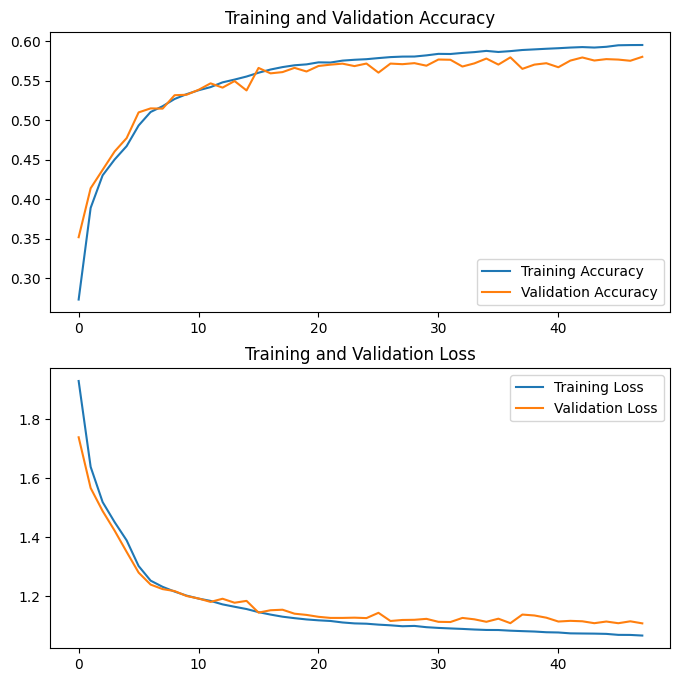

In [49]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
plot_train(h.history)

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5783636363636364}
8PSK test accuracy: 0.5462097611630322
AM-DSB test accuracy: 0.6696517412935323
AM-SSB test accuracy: 0.9154518950437318
BPSK test accuracy: 0.6195965417867435
CPFSK test accuracy: 0.6156233833419555
GFSK test accuracy: 0.6438831104507182
PAM4 test accuracy: 0.6853818917551846
QAM16 test accuracy: 0.16525212181727408
QAM64 test accuracy: 0.6643251379829402
QPSK test accuracy: 0.5443362378267556
WBFM test accuracy: 0.2880859375
Confusion matrix:
[[1052    8  587   38   24   21   14   29   54   84   15]
 [   3 1346  469   10    4   22    4    2    1    8  141]
 [  15   21 1884   35   16   22   15    4    4   16   26]
 [  16    5  621 1290    4   13   80    5   14   27    7]
 [  35   12  568   22 1190   24   16    8   15   31   12]
 [  10   29  548   20   19 1300    3    3    2    8   77]
 [   8   10  462   84   10   12 1355    3   13   15    5]
 [  92    4  351   33   27   12   22  331 1054   73    4]
 [  53 

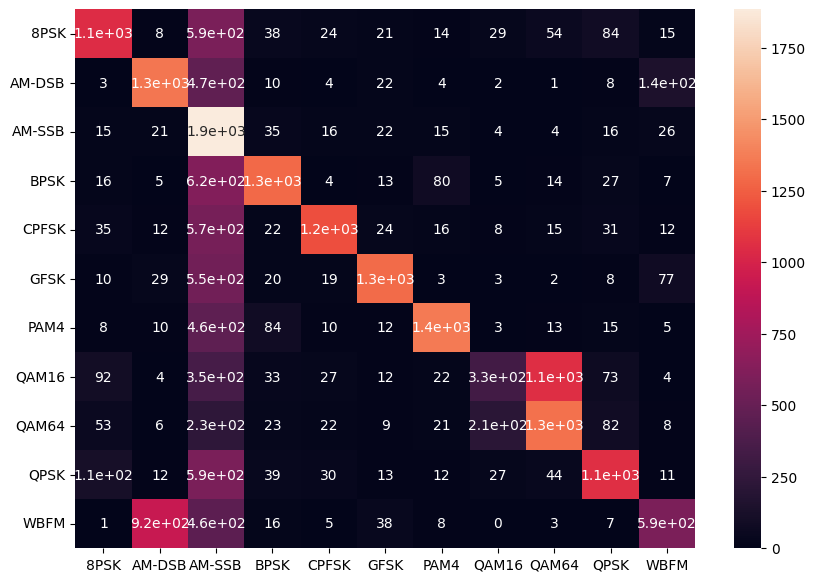

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5802727272727273}
8PSK test accuracy: 0.5412940557601262
AM-DSB test accuracy: 0.6784630940343782
AM-SSB test accuracy: 0.9208270297528997
BPSK test accuracy: 0.6237322515212982
CPFSK test accuracy: 0.6197866149369544
GFSK test accuracy: 0.6565656565656566
PAM4 test accuracy: 0.7022826614861584
QAM16 test accuracy: 0.1577079107505071
QAM64 test accuracy: 0.6564299424184261
QPSK test accuracy: 0.5436308926780341
WBFM test accuracy: 0.2739454094292804
Confusion matrix:
[[1029   11  602   34   25   12   11   38   53   78    8]
 [   4 1342  440   13    6   18    3    3    3    6  140]
 [  13   18 1826   32    8   26   14    4    2   14   26]
 [  21   11  579 1230   11    7   72    7    6   17   11]
 [  29   12  606   20 1278   32   19   10   12   29   15]
 [   6   24  527   16   19 1300   10    3    1    5   69]
 [  13    4  428  104   11    9 1446    7    8   17   12]
 [  75    9  409   28   26    7   23  311 1021   53   10]
 [

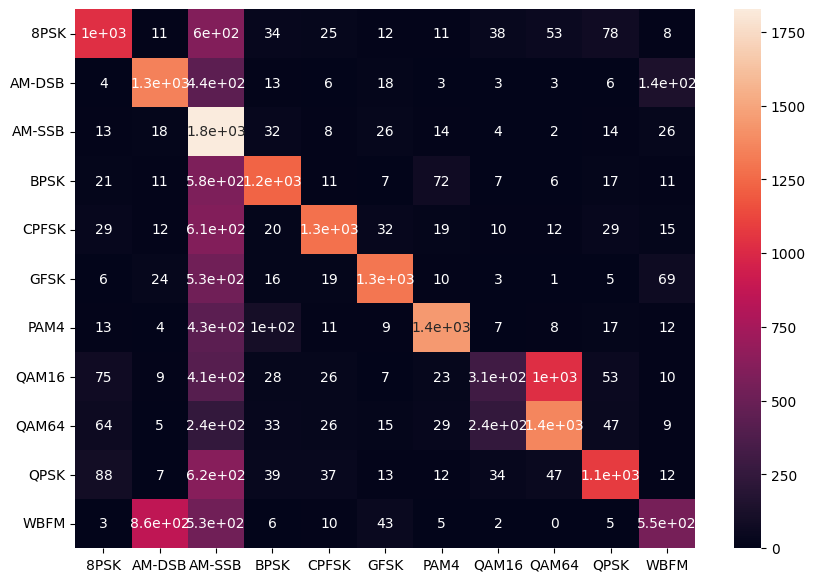

In [50]:
cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.10711150131694469
SNR: -18 -- Overall test accuracy: 0.09408602150537634
SNR: -16 -- Overall test accuracy: 0.10754716981132076
SNR: -14 -- Overall test accuracy: 0.1158371040723982
SNR: -12 -- Overall test accuracy: 0.1622119815668203
SNR: -10 -- Overall test accuracy: 0.2548476454293629
SNR: -8 -- Overall test accuracy: 0.39348591549295775
SNR: -6 -- Overall test accuracy: 0.5468895078922934
SNR: -4 -- Overall test accuracy: 0.6563055062166963
SNR: -2 -- Overall test accuracy: 0.7403169014084507
SNR: 0 -- Overall test accuracy: 0.8115808823529411
SNR: 2 -- Overall test accuracy: 0.8448905109489051
SNR: 4 -- Overall test accuracy: 0.8446511627906976
SNR: 6 -- Overall test accuracy: 0.8495102404274265
SNR: 8 -- Overall test accuracy: 0.8344007319304666
SNR: 10 -- Overall test accuracy: 0.8397435897435898
SNR: 12 -- Overall test accuracy: 0.8514492753623188
SNR: 14 -- Overall test accuracy: 0.8464951197870453
SNR: 16 -- Overall test accuracy: 0.83349

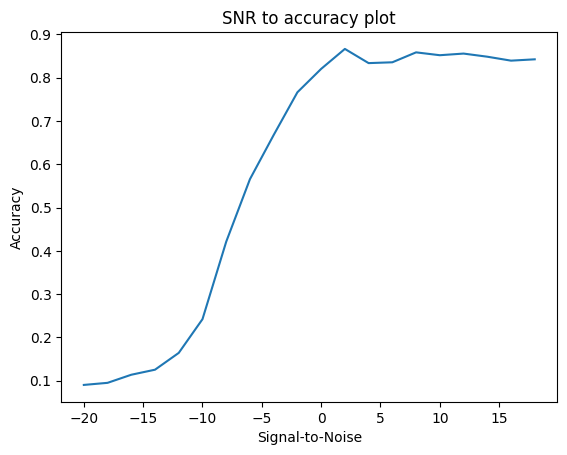

In [52]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_val)

# Save results

In [53]:
reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))

dump_results(
    model_name + "_results/",
    model=model,
    model_config=model_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    short_description="Smaller + dense, 48 epochs with more decay (16:/=10, 24:/=4, 32: /=4)",
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

INFO:tensorflow:Assets written to: cnn_1_radio_ml_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1_radio_ml_results/model_original/assets
2023-07-04 12:24:55.094070: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-04 12:24:55.094090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-04 12:24:55.094531: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1_radio_ml_results/model_original
2023-07-04 12:24:55.097806: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-04 12:24:55.097825: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1_radio_ml_results/model_original
2023-07-04 12:24:55.106297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-04 12:24:55.108451: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-04 12:24:55.203516: I

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5856818181818182}
8PSK test accuracy: 0.5467289719626168
AM-DSB test accuracy: 0.6741293532338308
AM-SSB test accuracy: 0.902818270165209
BPSK test accuracy: 0.600864553314121
CPFSK test accuracy: 0.6259699948266942
GFSK test accuracy: 0.6602278355621595
PAM4 test accuracy: 0.6914516944865958
QAM16 test accuracy: 0.36345481777334
QAM64 test accuracy: 0.5589563472152533
QPSK test accuracy: 0.5330599692465402
WBFM test accuracy: 0.28125
Confusion matrix:
[[1053   22  567   30   35   34   25   54   37   65    4]
 [   5 1355  430    5   13   50    6    1    1    5  139]
 [  22   45 1858   15   31   35   18    3    4   11   16]
 [  28   15  596 1251   20   21   92   19    6   26    8]
 [  29   19  538   12 1210   44   22   14   10   20   15]
 [   8   40  526    9   31 1333   10    3    2    7   50]
 [  16   19  446   53   18   19 1367   12    6   12    9]
 [  77    9  349   31   35   24   29  728  670   46    5]
 [  57   13  225 

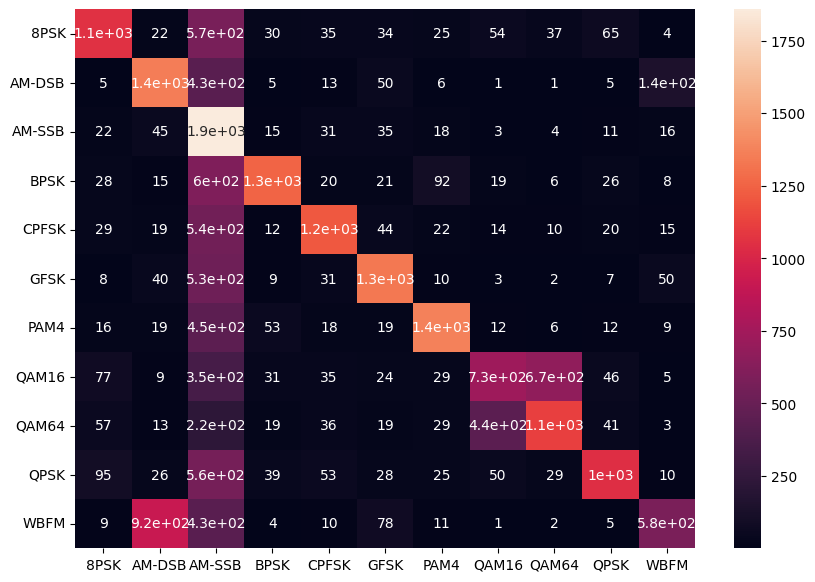

SNR: -20 -- Overall test accuracy: 0.10711150131694469
SNR: -18 -- Overall test accuracy: 0.0931899641577061
SNR: -16 -- Overall test accuracy: 0.10660377358490566
SNR: -14 -- Overall test accuracy: 0.1076923076923077
SNR: -12 -- Overall test accuracy: 0.16682027649769585
SNR: -10 -- Overall test accuracy: 0.2594644506001847
SNR: -8 -- Overall test accuracy: 0.3714788732394366
SNR: -6 -- Overall test accuracy: 0.5246053853296193
SNR: -4 -- Overall test accuracy: 0.655417406749556
SNR: -2 -- Overall test accuracy: 0.7711267605633803
SNR: 0 -- Overall test accuracy: 0.8115808823529411
SNR: 2 -- Overall test accuracy: 0.8658759124087592
SNR: 4 -- Overall test accuracy: 0.8567441860465116
SNR: 6 -- Overall test accuracy: 0.8584149599287623
SNR: 8 -- Overall test accuracy: 0.8719121683440073
SNR: 10 -- Overall test accuracy: 0.8626373626373627
SNR: 12 -- Overall test accuracy: 0.8541666666666666
SNR: 14 -- Overall test accuracy: 0.8660159716060337
SNR: 16 -- Overall test accuracy: 0.8505203

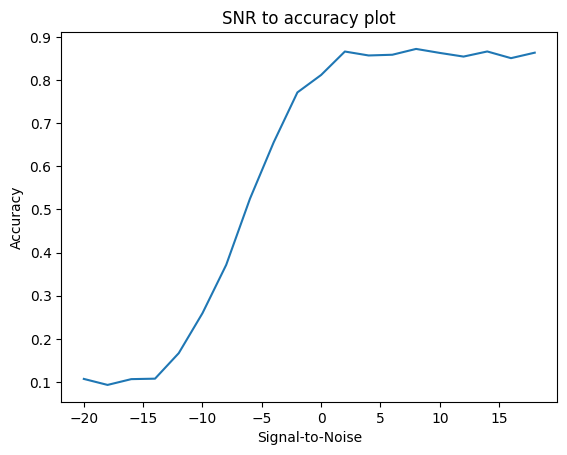

In [12]:
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

model_path = f"{model_name}_results/model_original"
model.save(model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)

cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

2023-07-03 14:09:22.710473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-03 14:09:22.710496: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-03 14:09:22.710640: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_test_results/model_original
2023-07-03 14:09:22.712732: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-03 14:09:22.712746: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_test_results/model_original
2023-07-03 14:09:22.719187: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-03 14:09:22.792666: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_test_results/model_original
2023-07-03 14:09:22.810128: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5359545454545455}
8PSK test accuracy: 0.34527518172377986
AM-DSB test accuracy: 0.6417910447761194
AM-SSB test accuracy: 0.9650145772594753
BPSK test accuracy: 0.6018251681075889
CPFSK test accuracy: 0.5913088463528194
GFSK test accuracy: 0.6230807330361565
PAM4 test accuracy: 0.6489630753667173
QAM16 test accuracy: 0.08686969545681478
QAM64 test accuracy: 0.6633216256899147
QPSK test accuracy: 0.5366478728856996
WBFM test accuracy: 0.1806640625
Confusion matrix:
[[ 665    3  650   46   30   32   10   55   54  381    0]
 [   1 1290  604    3    1   48    0    4    0    2   57]
 [   3    4 1986   17    8   28    4    4    0    4    0]
 [  18    2  678 1253    5   18   73   13    1   19    2]
 [  22    3  637   21 1143   34    5   27   14   25    2]
 [   6   44  620   15   18 1258    2    3    0    6   47]
 [  16    3  522  101    7   12 1283   17    1   14    1]
 [  90    3  407   47   18   21   24  174 1134   84    1]
 [  50

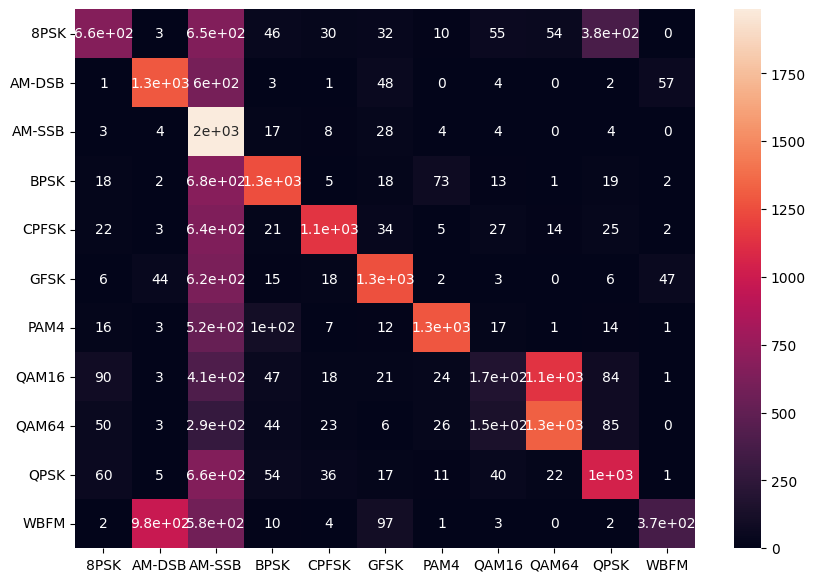

SNR: -20 -- Overall test accuracy: 0.1044776119402985
SNR: -18 -- Overall test accuracy: 0.08870967741935484
SNR: -16 -- Overall test accuracy: 0.09905660377358491
SNR: -14 -- Overall test accuracy: 0.07782805429864253
SNR: -12 -- Overall test accuracy: 0.11889400921658987
SNR: -10 -- Overall test accuracy: 0.19113573407202217
SNR: -8 -- Overall test accuracy: 0.335387323943662
SNR: -6 -- Overall test accuracy: 0.4958217270194986
SNR: -4 -- Overall test accuracy: 0.6065719360568383
SNR: -2 -- Overall test accuracy: 0.6963028169014085
SNR: 0 -- Overall test accuracy: 0.7564338235294118
SNR: 2 -- Overall test accuracy: 0.802007299270073
SNR: 4 -- Overall test accuracy: 0.7776744186046511
SNR: 6 -- Overall test accuracy: 0.8032056990204809
SNR: 8 -- Overall test accuracy: 0.7950594693504117
SNR: 10 -- Overall test accuracy: 0.8113553113553114
SNR: 12 -- Overall test accuracy: 0.8088768115942029
SNR: 14 -- Overall test accuracy: 0.7843833185448092
SNR: 16 -- Overall test accuracy: 0.778618

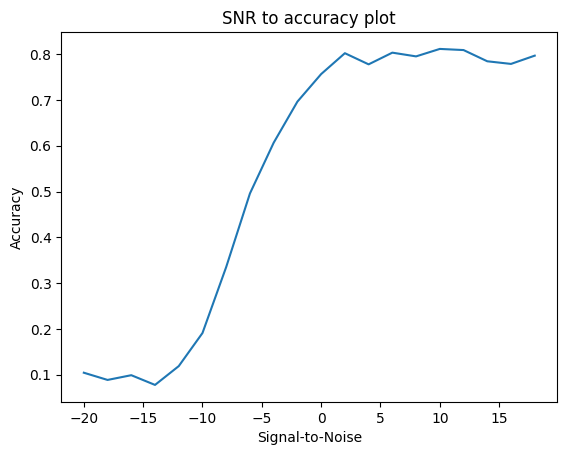

In [19]:
representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)

In [38]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


11it [00:00, 578.21it/s]
